# Nederlands-Fries

- https://leren.windesheim.nl/d2l/le/lessons/103162/topics/927096

## 1. Business Understanding

Vertaal Nederlandse zinnen naar het Fries.

## 2. Data Understanding

School heeft ons al de code aangeleverd die een tekstcorpus van het Fryske Akademy downloadt, alsook deze gegevens omgezet naar een CSV-bestand.

### 2.1. Bibliotheken importeren

In [1]:
!pip install keras_nlp


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import os
import re
import keras
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_nlp
import matplotlib.pyplot as plt

from keras import layers
from sklearn.model_selection import train_test_split

2024-10-14 06:17:55.889614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 06:17:56.046079: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 06:17:56.089310: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 06:17:56.401255: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Nu zet ik even de logging uit, in hoeverre mogelijk, want TensorFlow op NVIDIA is vrij verbeus:

In [3]:
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

Als je in een Jupyter-devcontainer zit, wordt je niet direct in de juiste map gezet:

In [4]:
if "NederlandsFries.ipynb" not in os.listdir('.'):
    os.chdir("Thema 3")

### 2.2. Inlezen `dataset.csv`
De corpus bevat twee simpele kolommen, een met de Nederlandse tekst, en een met de Friese vertaling.

In [5]:
dataset_df = pd.read_csv("Data/dataset.csv")
dataset_df.info()
dataset_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   nederlands  173912 non-null  object
 1   fries       173912 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


,nederlands,fries
0,we hebben de burgemeester het advies gegeven o...,wy hawwe de boargemaster it advys jun om it ka...
1,we hebben de burgemeester het advies gegeven o...,wy hawwe de boargemaster it advys jun om it ka...
2,een plotselinge dood,in hastige dea
3,een plotselinge dood,in unferwachte dea
4,zijn plotseling overlijden,syn hastich ferstjerren


### 2.3. Inzicht zinlengte
We zien dat de teksten maximaal 60 woorden bevatten, en gemiddeld 9 woorden. Gelukkig niet te veel, zo kunnen we hem makkelijker trainen.

In [6]:
hoeveelheid_woorden_nederlands = dataset_df['nederlands'].apply(lambda txt: len(txt.split()))
print(f"Min {hoeveelheid_woorden_nederlands.min()} Max {hoeveelheid_woorden_nederlands.max()} gemiddeld {hoeveelheid_woorden_nederlands.mean()}")

Min 1 Max 59 gemiddeld 9.066044896269378


In [7]:
hoeveelheid_woorden_fries = dataset_df['fries'].apply(lambda txt: len(txt.split()))
print(f"Min {hoeveelheid_woorden_fries.min()} Max {hoeveelheid_woorden_fries.max()} gemiddeld {hoeveelheid_woorden_fries.mean()}")

Min 1 Max 60 gemiddeld 9.237137172823036


### 2.4. Inzicht woordhoeveelheid
Er zijn zo'n 70 duizend Nederlands woorden en 75 duizen Friese woorden in de dataset, dus dat is nog wel te overzien.

In [8]:
len(np.unique(np.hstack(dataset_df['nederlands'].apply(lambda txt: np.array(txt.split())))))

70245

In [9]:
len(np.unique(np.hstack(dataset_df['fries'].apply(lambda txt: np.array(txt.split())))))

74319

## 3. Data Preparation

Nu ga ik de data voorbereiden voor het modelleren.

### 3.1. Start en eindtokens toevoegen

In [6]:
START_TOKEN = "[begin]"
END_TOKEN = "[eind]"

def omringMetBeginEnEinde(tekst):
    return f"{START_TOKEN} {tekst} {END_TOKEN}"

dataset_df['fries'] = dataset_df['fries'].apply(omringMetBeginEnEinde)

### 3.2. Splitsen tussen traindata testdata

In [7]:
train_pairs, test_pairs = train_test_split(
    dataset_df,
    test_size=0.2,
    shuffle = True,
)

train_pairs.head()

,nederlands,fries
19014,het heiligbeen bestaat uit 5 wervels die bij o...,[begin] de krusbonke bestiet ut fiif wringen d...
172964,het fel verlichte chineeskantonees indonesisch...,[begin] it fel ferljochte sineeskkantoneesk yn...
32643,het is niet toegestaan alcohol te verstrekken ...,[begin] it is net tastien om alkohol te jaan o...
154018,iemand fries leren,[begin] immen sineesk leare [eind]
137943,het nieuwste model,[begin] it leste model [eind]


### 3.3. Tekstvectorisatie
Eerst probeer ik een simpele `TextVectorization`, die woorden indeeld op frequentie.

In [12]:
dutch_vocab_size   = 20000
frisian_vocab_size = 20000

dutch_maxlen   = 20
frisian_maxlen = 20

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


In [13]:
dutch_text_vectorization = layers.TextVectorization(
    max_tokens=dutch_vocab_size,
    output_mode="int",
    output_sequence_length=dutch_maxlen,
)

dutch_text_vectorization.adapt(dataset_df['nederlands'])

In [14]:
frisian_text_vectorization = layers.TextVectorization(
    max_tokens=frisian_vocab_size,
    output_mode="int",
    output_sequence_length=frisian_maxlen + 1, # <--- om ervoor te zorgen dat hij de volgende gaat voorspellen
    standardize=custom_standardization,
)

frisian_text_vectorization.adapt(dataset_df['fries'])

### 3.4. SequenceLength
Ik weet niet precies waar ik dit moet neerzetten, maar ik heb geprobeerd [`SentencePiece`](https://arxiv.org/abs/1808.06226) te integreren. Dit is een geavanceerde tokenizer die veelvoorkomende woorden simpelweg tokeniseert, maar wat zeldzame woorden opsplitst in een soort van lettergrepen (woorddelen) die dan aan elkaar geplakt worden. Ook spaties en interpunctie zijn hiermee opgenomen, anders dan TextVectorization.

In [11]:
DUTCH_TOKENIZER_PATH = "Data/dutch_tokenizer.model"
FRISIAN_TOKENIZER_PATH = "Data/frisian_tokenizer.model"

dutch_vocab_size   = 4000
frisian_vocab_size = 4000

dutch_maxlen   = 50
frisian_maxlen = 50

In [ ]:
train_tokenizer = not os.path.exists(DUTCH_TOKENIZER_PATH)

if train_tokenizer:
    with open('Data/dutch_texts.txt', 'w') as f:
        for line in dataset_df['nederlands']:
            f.write(line + "\n")

    # Train de tokenizer
    spm.SentencePieceTrainer.train(
        input='Data/dutch_texts.txt',
        model_prefix=DUTCH_TOKENIZER_PATH.split('.')[0],
        vocab_size=dutch_vocab_size,
        character_coverage=0.9995,
        model_type='bpe'
    )

In [ ]:
dutch_tokenizer = spm.SentencePieceProcessor(model_file=DUTCH_TOKENIZER_PATH)
dutch_tokenizer.bos_id()

def dutch_text_vectorization(input_string):
    tokenized_sentence = dutch_tokenizer.encode(input_string, out_type=int)
    # Vul of snijd de tokens af tot de maximale lengte
    if len(tokenized_sentence) < dutch_maxlen:
        tokenized_sentence += [0] * (dutch_maxlen - len(tokenized_sentence))
    else:
        tokenized_sentence = tokenized_sentence[:dutch_maxlen]
    return tokenized_sentence

def decode_dutch(token_ids):
    # Filter het `END_TOKEN` als het aanwezig is
    if END_TOKEN in token_ids:
        token_ids = token_ids[:token_ids.index(END_TOKEN)]

    return decoded_sentence = dutch_tokenizer.decode(token_ids)

sample_text = "dit is een voorbeeldzin" # <-- zaak dat je wel een zin zonder hoofdletters gebruikt!
tokenized_text = dutch_tokenizer.encode(sample_text, out_type=int)
print("Indices:", tokenized_text)
print("Teruggedecodeerd:", decode_dutch(tokenized_text))


In [ ]:
train_tokenizer = not os.path.exists(FRISIAN_TOKENIZER_PATH)

if train_tokenizer:
    with open('Data/frisian_texts.txt', 'w') as f:
        for line in dataset_df['fries']:
            f.write(line + "\n")

    spm.SentencePieceTrainer.train(
        input='Data/frisian_texts.txt',
        model_prefix=FRISIAN_TOKENIZER_PATH.split('.')[0],
        vocab_size=frisian_vocab_size,
        character_coverage=0.9995,
        model_type='bpe'
)

In [ ]:
frisian_tokenizer = spm.SentencePieceProcessor(model_file=FRISIAN_TOKENIZER_PATH)

def frisian_text_vectorization(input_string):
    maxlen = frisian_maxlen + 1
    tokenized_sentence = frisian_tokenizer.encode(input_string, out_type=int)
    if len(tokenized_sentence) < maxlen:
        tokenized_sentence += [0] * (maxlen - len(tokenized_sentence))
    else:
        tokenized_sentence = tokenized_sentence[:maxlen]
    return tokenized_sentence

def decode_frisian(token_ids):
    if END_TOKEN in token_ids:
        token_ids = token_ids[:token_ids.index(END_TOKEN)]

    return frisian_tokenizer.decode(token_ids)

### 3.4. Dataset (TextVectorization)
Voor TextVectorization, is het opzetten van de dataset een stuk eenvoudiger:

In [15]:
batch_size = 64

def format_dataset(dutch, frisian):
    dutch = dutch_text_vectorization(dutch)
    frisian = frisian_text_vectorization(frisian)

    return ({
        "dutch": dutch,
        "frisian": frisian[:, :-1],
    }, frisian[:, 1:])

def make_dataset(pairs):
    dutch_texts = pairs['nederlands']
    frisian_texts = pairs['fries']
    dutch_texts = list(dutch_texts)
    frisian_texts = list(frisian_texts)
    dataset = tf.data.Dataset.from_tensor_slices((dutch_texts, frisian_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=16)
    return dataset.shuffle(2048).prefetch(16).cache() #in memory caching ivm performance

train_ds = make_dataset(train_pairs)
test_ds = make_dataset(test_pairs)

In [16]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['dutch'].shape: {inputs['dutch'].shape}")
    print(f"inputs['frisian'].shape: {inputs['frisian'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['dutch'].shape: (64, 20)
inputs['frisian'].shape: (64, 20)
targets.shape: (64, 20)


2024-10-14 06:18:46.485048: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-14 06:18:46.487637: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### 3.5. Dataset (SentencePiece)
Maar voor SentencePiece is het een stukje moeilijker:

In [ ]:
batch_size = 64

def encode_text(dutch, frisian):
    dutch_tokens = np.vectorize(dutch_text_vectorization)(dutch)
    frisian_tokens = np.vectorize(frisian_text_vectorization)(frisian)

    # Dataset werkt mn met numpy
    return np.array(dutch_tokens, dtype=np.int32), np.array(frisian_tokens, dtype=np.int32)

def format_dataset(dutch: tf.Tensor, frisian: tf.Tensor):
    print("Frisian", frisian)
    return ({
        "dutch": dutch,
        "frisian": frisian[:, :-1],
    }, frisian[:, 1:])

def make_dataset(pairs):
    dutch_texts = pairs['nederlands']
    frisian_texts = pairs['fries']
    dutch_texts = list(dutch_texts)
    frisian_texts = list(frisian_texts)
    dataset = tf.data.Dataset.from_tensor_slices((dutch_texts, frisian_texts))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.map(format_dataset, num_parallel_calls=16)
    return dataset #.shuffle(2048).prefetch(16).cache() #in memory caching ivm performance

In [ ]:
tokenized_pairs = train_pairs.copy()
tokenized_pairs['nederlands'] = tokenized_pairs['nederlands'].apply(dutch_text_vectorization)
tokenized_pairs['fries'] = tokenized_pairs['fries'].apply(frisian_text_vectorization)

In [ ]:
tokenized_test_pairs = test_pairs.copy()
tokenized_test_pairs['nederlands'] = tokenized_test_pairs['nederlands'].apply(dutch_text_vectorization)
tokenized_test_pairs['fries'] = tokenized_test_pairs['fries'].apply(frisian_text_vectorization)


In [ ]:
train_ds = make_dataset(tokenized_pairs)
test_ds = make_dataset(tokenized_test_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['dutch'].shape: {inputs['dutch'].shape}")
    print(f"inputs['frisian'].shape: {inputs['frisian'].shape}")
    print(f"targets.shape: {targets.shape}")
train_ds

### 3.6. Friese inbeddings
Iets wat ik laat nog op de zondagavond heb geprobeerd, is om zelfs [GloVe embeddings te maken](https://github.com/stanfordnlp/GloVe) op basis van de [Friese Wikipedia](https://dumps.wikimedia.org/fywiki/20241001/), met [wikiextractor](https://github.com/attardi/wikiextractor). Helaas duurde dit te lang om nog te proberen, maar zou dit wel graag in de toekomst willen proberen.

In [ ]:
#!/bin/bash
## Download dataset
wget https://dumps.wikimedia.org/fywiki/20241001/fywiki-20241001-pages-articles.xml.bz2
mv fywiki-20241001-pages-articles.xml.bz2 Data/

## Extraheer alle teksts
python -m wikiextractor.WikiExtractor.py -o friese_wiki_txt Data/fywiki-20241001-pages-articles.xml.bz2

## Voeg het allemaal smaen
cat friese_wiki_txt/* > Data/friese_wiki_corpus.txt

## Maak er een GloVe model van
CORPUS=Data/friese_wiki_corpus.txt
VOCAB_FILE=vocab.txt
COOCCURRENCE_FILE=cooccurrence.bin
COOCCURRENCE_SHUF_FILE=cooccurrence.shuf.bin
BUILDDIR=GloVe/build
SAVE_FILE=friese_vectors
VERBOSE=2
MEMORY=4.0
VECTOR_SIZE=300
MAX_ITER=15
WINDOW_SIZE=10
BINARY=2
NUM_THREADS=8
X_MAX=10

echo "Building vocabulary..."
$BUILDDIR/vocab_count -min-count 5 -verbose $VERBOSE < $CORPUS > $VOCAB_FILE || exit

echo "Counting co-occurrences..."
$BUILDDIR/cooccur -memory $MEMORY -vocab-file $VOCAB_FILE -window-size $WINDOW_SIZE -verbose $VERBOSE < $CORPUS > $COOCCURRENCE_FILE || exit

echo "Shuffling co-occurrences..."
$BUILDDIR/shuffle -memory $MEMORY -verbose $VERBOSE < $COOCCURRENCE_FILE > $COOCCURRENCE_SHUF_FILE || exit

echo "Training GloVe model..."
$BUILDDIR/glove -save-file $SAVE_FILE -threads $NUM_THREADS -input-file $COOCCURRENCE_SHUF_FILE -x-max $X_MAX -iter $MAX_ITER -vector-size $VECTOR_SIZE -binary $BINARY -vocab-file $VOCAB_FILE -verbose $VERBOSE || exit

echo "Training complete. Embeddings saved to $SAVE_FILE.txt"

## 4. Modeling

Nu we de tekst voorbereid hebben, kunnen we beginnen met modeleren. Ik heb gekeken of de code uit [`keras_nlp`](https://keras.io/keras_nlp/) gebruikt kon worden, in plaats van de code van de auteurs van de transformer, maar dit werkte niet even fijn als de originele code.
### 4.1. Opzet transformer-lagen

In [17]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)

        # Initialize the embeddings for tokens and positions
        self.token_embeddings = layers.Embedding(           # regular embedding
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(        # position embedding
            input_dim=sequence_length, output_dim=output_dim)
        # Some relevant settings for subsequent layers
        # Definnig the settings as part of the object (self.) makes it
        # easier to apply them consistently in the call() method
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]                               # Length of the input sentences
        positions = tf.range(start=0, limit=length, delta=1)        # 0-indexed positions of tokens in the sequences
        # Generate the actual position embeddings
        embedded_tokens = self.token_embeddings(inputs)             # Regular embeddings of the tokens
        embedded_positions = self.position_embeddings(positions)    # Position embeddings
        # We maken hier een 2e embeddingspace voor de positie die we daarna bij het origineel optellen
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return keras.ops.not_equal(inputs, 0) #geneer mask basis van waar de input niet 0 is.Zodat we de input niet hoeven te padden

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [18]:
class TransformerEncoder(layers.Layer):                              # Our transformer encoder layer inherits from keras.layers.Layer
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):   # the constructor of our encoder layer
        super().__init__(**kwargs)                                   # calls the constructor of the parent class (keras.layers.Layer)

        # Store a whole bunch settings and initialise the building blocks for our encoder layer
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # Multi-head attention building block
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        # Dense building block
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        # Layer normalisation building block, 1 and 2 are used to normalise the output of the attention and dense blocks respectively
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        # Here we actually build the encoder layer

        # If we define a mask for attention, we need to perform some preprocessing on it
        if mask is not None:
            mask = mask[:, tf.newaxis, :] #padding mask (negeer alle paffing) voeg een dimensie toe. Transformer verwacht 3D of meer. Embedding layer genereerd 2d layer

        # Define the attention part of the encoder
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        # Apply layer normalisation to the attention output
        proj_input = self.layernorm_1(inputs + attention_output)
        # Apply the dense part of the encoder
        proj_output = self.dense_proj(proj_input)
        # Apply layer normalisation to the dense output, and return the encoder
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        # Return all the configuration settings for this layer

        # Get the configuration settings from the parent class
        config = super().get_config()
        # Add the config settings of our own layer
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [19]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True #anders geen masking mogelijk

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        #prevents the model from learning to copy the next token from the input to the output by hiden it
        # [[1,0,0],
        #  [1,1,0],
        #  [1,1,1]]
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        #Replicate it along the batch axis to get an matrix of shape (batch_size, sequence_length, sequence_length)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        #retrieve the casual mask
        padding_mask = None
        if mask is not None: #prepare the input mask that describes padding locations in the target_sequence
            padding_mask = keras.cast(
                mask[:, tf.newaxis, :], dtype="int32") #extra dim aangezien transfo deze verwacht
            padding_mask = keras.minimum(padding_mask, causal_mask)#merge both masks (input padding en volgende woord padding)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)# pass the casual mask tot the first attention layer, which performs self attention over the target sequence
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask, #pass the combined mask to the second attention layer, which relates the source sequence to the target sequence
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

### 4.2. Eerste model
Ik probeer eerst maar eens een transformer-model op te zetten. Ik moet zeggen dat ik hier heel lang mee bezig ben geweest, want ik liep tegen een hoop kleine foutjes aan, van de verkeerde activatie, tot een verkeerde tokenizer, tot allerlei kerasproblemen.

In [20]:
embed_dim = 512
dense_dim = 1024
num_heads = 8


encoder_inputs = keras.Input(shape=(dutch_maxlen,), dtype="int64", name="dutch")
decoder_inputs = keras.Input(shape=(frisian_maxlen,), dtype="int64", name="frisian")

encoder_embedding = PositionalEmbedding(dutch_maxlen, dutch_vocab_size, embed_dim, name="encoder_embedding")(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads, name="encoder_outputs")(encoder_embedding)

decoder_embedding = PositionalEmbedding(frisian_maxlen, frisian_vocab_size, embed_dim, name="decoder_embedding")(decoder_inputs)
decoder = TransformerDecoder(embed_dim, dense_dim, num_heads, name="decoder")(decoder_embedding, encoder_outputs)


decoder_dropout = layers.Dropout(0.5, name="decoder_dropout")(decoder)
decoder_outputs = layers.Dense(frisian_vocab_size, activation="softmax", name="decoder_outputs")(decoder_dropout)


model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'encoder_outputs' (of type TransformerEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ dutch (InputLayer)  │ (None, 20)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ frisian             │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 20, 512)   │ 10,250,240 │ dutch[0][0]       │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 20)        │          0 │ dutch[0][0]       │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 20, 512)   │ 10,250,240 │ frisian[0][0]     │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_outputs     │ (None, 20, 512)   │  9,453,568 │ encoder_embeddin… │
│ (TransformerEncode… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 20, 512)   │ 17,856,000 │ decoder_embeddin… │
│ (TransformerDecode… │                   │            │ encoder_outputs[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dropout     │ (None, 20, 512)   │          0 │ decoder[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_outputs     │ (None, 20, 20000) │ 10,260,000 │ decoder_dropout[… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 58,070,048 (221.52 MB)

 Trainable params: 58,070,048 (221.52 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
history = model.fit(train_ds, epochs=3, validation_data=test_ds)

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
I0000 00:00:1728886751.990405    5243 serv

1050/2174 ━━━━━━━━━━━━━━━━━━━━ 43s 39ms/step - accuracy: 0.2203 - loss: 6.0614

W0000 00:00:1728886805.014481    5242 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-10-14 06:20:06.323106: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_76', 16 bytes spill stores, 16 bytes spill loads

2024-10-14 06:20:06.685137: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_76', 8 bytes spill stores, 8 bytes spill loads

2024-10-14 06:20:06.708172: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_76', 200 bytes spill stores, 168 bytes spill loads

2024-10-14 06:20:06.810481: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warni

2174/2174 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1771 - loss: 5.9133

W0000 00:00:1728886859.828688    5244 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1728886866.384635    5244 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-10-14 06:21:07.151413: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21', 8 bytes spill stores, 8 bytes spill loads

2024-10-14 06:21:07.330161: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21', 16 bytes spill stores, 16 bytes spill loads

2024-10-14 06:21:07.595539: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in

2174/2174 ━━━━━━━━━━━━━━━━━━━━ 124s 50ms/step - accuracy: 0.1771 - loss: 5.9132 - val_accuracy: 0.1200 - val_loss: 5.4025
Epoch 2/3
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 90s 42ms/step - accuracy: 0.1217 - loss: 5.3867 - val_accuracy: 0.1286 - val_loss: 5.4763
Epoch 3/3
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 92s 42ms/step - accuracy: 0.1282 - loss: 5.3286 - val_accuracy: 0.1306 - val_loss: 5.2569


Zoals je kunt zien, is dit vrij slecht:

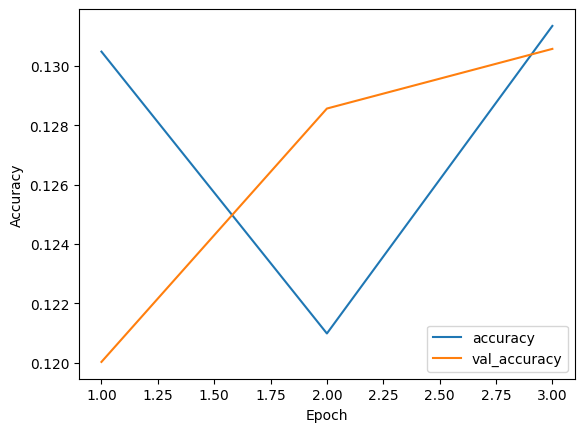

In [24]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### 4.3. Masked loss en custom schedule
Ik heb meerdere dagen vastgezeten, maar iets wat goed werkte is de [`CustomSchedule` (leerschema)](https://www.tensorflow.org/text/tutorials/transformer#set_up_the_optimizer) want door het leertempo eerst lager te zetten en dan vervolgens op te krikken, krijgt het model meer tijd om begrip te krijgen over de invoerdata (mn. goeie validatie) en [masked loss](https://www.tensorflow.org/text/tutorials/transformer#set_up_the_loss_and_metrics) want de sequence wordt gepad met lege tokens als het niet voldoet aan de `frisian_maxlen`.

In [26]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


Ook interessant is de verlaging van hyperparameterwaardes, deze waren een stuk hoger dan nodig voor goeie resultaten.

In [22]:
embed_dim = 128
dense_dim = 1024
num_heads = 8

encoder_inputs = keras.Input(shape=(dutch_maxlen,), dtype="int64", name="dutch")
decoder_inputs = keras.Input(shape=(frisian_maxlen,), dtype="int64", name="frisian")

encoder_embedding = PositionalEmbedding(dutch_maxlen, dutch_vocab_size, embed_dim, name="encoder_embedding")(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads, name="encoder_outputs")(encoder_embedding)

decoder_embedding = PositionalEmbedding(frisian_maxlen, frisian_vocab_size, embed_dim, name="decoder_embedding")(decoder_inputs)
decoder = TransformerDecoder(embed_dim, dense_dim, num_heads, name="decoder")(decoder_embedding, encoder_outputs)

decoder_dropout = layers.Dropout(0.5, name="decoder_dropout")(decoder)
decoder_outputs = layers.Dense(frisian_vocab_size, activation="softmax", name="decoder_outputs")(decoder_dropout)


model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ dutch (InputLayer)  │ (None, 20)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ frisian             │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 20, 128)   │  2,562,560 │ dutch[0][0]       │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 20)        │          0 │ dutch[0][0]       │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 20, 128)   │  2,562,560 │ frisian[0][0]     │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_outputs     │ (None, 20, 128)   │    791,296 │ encoder_embeddin… │
│ (TransformerEncode… │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 20, 128)   │  1,319,040 │ decoder_embeddin… │
│ (TransformerDecode… │                   │            │ encoder_outputs[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dropout     │ (None, 20, 128)   │          0 │ decoder[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_outputs     │ (None, 20, 20000) │  2,580,000 │ decoder_dropout[… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,815,456 (37.44 MB)

 Trainable params: 9,815,456 (37.44 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
learning_rate = CustomSchedule(embed_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

model.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])


In [28]:
history = model.fit(train_ds, epochs=3, validation_data=test_ds)

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
W0000 00:00:1728887287.993846    5240 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-10-14 06:28:10.050172: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 132 bytes spill stores, 132 bytes spill loads

2024-10-14 06:28:10.293521: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 4 bytes spill stores, 4 bytes spill loads

2024-10-14 06:28:10.

1047/2174 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 8.3347 - masked_accuracy: 0.0827

W0000 00:00:1728887311.356882    5244 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-10-14 06:28:32.055765: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_76', 4 bytes spill stores, 4 bytes spill loads

2024-10-14 06:28:32.702216: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 20 bytes spill stores, 20 bytes spill loads

2024-10-14 06:28:32.746311: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_76', 16 bytes spill stores, 16 bytes spill loads

2024-10-14 06:28:32.808915: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] p

2170/2174 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.2805 - masked_accuracy: 0.1535

W0000 00:00:1728887335.046844    5241 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1728887338.241993    5245 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-10-14 06:28:58.495069: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21', 4 bytes spill stores, 4 bytes spill loads

2024-10-14 06:28:59.263543: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21', 16 bytes spill stores, 16 bytes spill loads

2024-10-14 06:28:59.313166: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are sp

2174/2174 ━━━━━━━━━━━━━━━━━━━━ 59s 20ms/step - loss: 7.2770 - masked_accuracy: 0.1538 - val_loss: 3.8330 - val_masked_accuracy: 0.4993
Epoch 2/3
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - loss: 3.7845 - masked_accuracy: 0.5153 - val_loss: 2.8708 - val_masked_accuracy: 0.6121
Epoch 3/3
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - loss: 2.8337 - masked_accuracy: 0.6237 - val_loss: 2.3702 - val_masked_accuracy: 0.6785


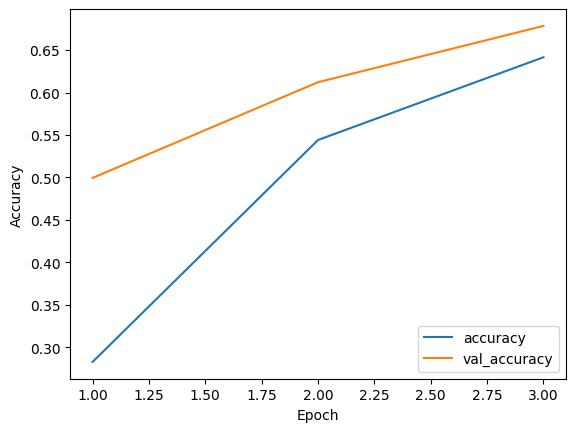

In [29]:
acc=history.history['masked_accuracy']
val_acc=history.history['val_masked_accuracy']
epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [30]:
import numpy as np
import random
fy_vocab = frisian_text_vectorization.get_vocabulary()
fy_index_lookup = dict(zip(range(len(fy_vocab)), fy_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = dutch_text_vectorization([input_sentence])
    decoded_sentence = START_TOKEN
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = frisian_text_vectorization(
            [decoded_sentence])
        predictions = model(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = fy_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token + str(sampled_token_index)
        if sampled_token == END_TOKEN:
            break
    return decoded_sentence

test_dutch_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_dutch_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
n


ValueError: Input 1 of layer "functional_5" is incompatible with the layer: expected shape=(None, 20), found shape=(1, 21)

### 4.4. Meer epochs
Online heb ik gehoord dat als je een goeie convergentie wilt hebben, je met een hoop epochs moet werken. Zo heb ik eerst maar eens $30$ epochs aangezet, om te testen wat dat doet.

In [ ]:
embed_dim = 128
dense_dim = 1024
num_heads = 8


encoder_inputs = keras.Input(shape=(dutch_maxlen,), dtype="int64", name="dutch")
decoder_inputs = keras.Input(shape=(frisian_maxlen,), dtype="int64", name="frisian")

# encoder_embedding = TokenAndPositionEmbedding(dutch_vocab_size, dutch_maxlen, embed_dim)(encoder_inputs)
encoder_embedding = PositionalEmbedding(dutch_maxlen, dutch_vocab_size, embed_dim, name="encoder_embedding")(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads, name="encoder_outputs")(encoder_embedding)


# decoder_embedding = TokenAndPositionEmbedding(frisian_vocab_size, frisian_maxlen, embed_dim)(decoder_inputs)
decoder_embedding = PositionalEmbedding(frisian_maxlen, frisian_vocab_size, embed_dim, name="decoder_embedding")(decoder_inputs)
decoder = TransformerDecoder(embed_dim, dense_dim, num_heads, name="decoder")(decoder_embedding, encoder_outputs)


decoder_dropout = layers.Dropout(0.5, name="decoder_dropout")(decoder)
decoder_outputs = layers.Dense(frisian_vocab_size, activation="softmax", name="decoder_outputs")(decoder_dropout)


model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

learning_rate = CustomSchedule(embed_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

model.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

history = model.fit(train_ds, epochs=30, validation_data=test_ds)

Helaas is de uitvoer nu verloren gegaan, maar dit flatlinede op zo'n $80 \%$, maar het gevalideerde was zo'n $75 %$ en duidde op een klein beetje overfitting, maar geen extreme gevallen.

In [ ]:
acc=history.history['masked_accuracy']
val_acc=history.history['val_masked_accuracy']
epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
#nog even testen
import numpy as np
import random
fy_vocab = frisian_text_vectorization.get_vocabulary()
fy_index_lookup = dict(zip(range(len(fy_vocab)), fy_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = dutch_text_vectorization([input_sentence])
    decoded_sentence = START_TOKEN
    indices = []

    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence: tf.Tensor = frisian_text_vectorization([decoded_sentence])
        tokenized_target_sentence = tokenized_target_sentence[:, :-1]
        predictions = model([tokenized_input_sentence, tokenized_target_sentence])

        # Pak altijd de laatste voorspelling
        sampled_token_index = np.argmax(predictions[0, i, :])
        indices.append(sampled_token_index)

        sampled_token = fy_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == END_TOKEN:
            break

    return decoded_sentence

def clean(str: str) -> str:
    return str.lower().replace(START_TOKEN + ' ', '').replace(' ' + END_TOKEN, '').replace('[unk]', '?')

for _ in range(10):
    input_sentence, daadwerkelijk = random.choice(list(test_pairs.values))
    print("-----------------------------------------------------------")
    print("NL:", input_sentence)
    print("FY:", clean(daadwerkelijk))
    print("AI:", clean(decode_sequence(input_sentence)))


### 4.5. Tuning van de Hyperparameters
Hieronder heb ik een tabel met een paar geprobeerde stappen om de accuraatheid een stukje omhoog te krikken, zonder dat het model nog meer overfit.
|Probeersel         |Berendering                        |Effect
|-                  |-                                  |-
`warmup_steps` van $4000$ naar $8000$ te doen|Ik zag dat het model op stap 1 bijvoorbeeld een veel hogere gevalideerde accuraatheid had|De gevalideerde accuraatheid bleek een tikje lager hiermee.
|Dropout van $0.5$ naar $0.3$ verlagen |Misschien is hij nu wel iets te onzeker over wat ie doet|Zorgt voor slechter overfit
|Verhogen van `embed_dim` van $128$ naar $512$|Meer om mee te werken |Was een beetje beter, maar duurde tig keer langer om te trainen.


In [24]:
embed_dim = 512
dense_dim = 1024
num_heads = 8


encoder_inputs = keras.Input(shape=(dutch_maxlen,), dtype="int64", name="dutch")
decoder_inputs = keras.Input(shape=(frisian_maxlen,), dtype="int64", name="frisian")

encoder_embedding = PositionalEmbedding(dutch_maxlen, dutch_vocab_size, embed_dim, name="encoder_embedding")(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads, name="encoder_outputs")(encoder_embedding)

decoder_embedding = PositionalEmbedding(frisian_maxlen, frisian_vocab_size, embed_dim, name="decoder_embedding")(decoder_inputs)
decoder = TransformerDecoder(embed_dim, dense_dim, num_heads, name="decoder")(decoder_embedding, encoder_outputs)


decoder_dropout = layers.Dropout(0.5, name="decoder_dropout")(decoder)
decoder_outputs = layers.Dense(frisian_vocab_size, activation="softmax", name="decoder_outputs")(decoder_dropout)


model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

learning_rate = CustomSchedule(embed_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

model.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

history = model.fit(train_ds, epochs=8, validation_data=test_ds)

Epoch 1/8


W0000 00:00:1728858065.077907   49003 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-10-13 22:21:07.843244: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 4 bytes spill stores, 4 bytes spill loads

2024-10-13 22:21:08.300005: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_41', 12 bytes spill stores, 12 bytes spill loads

2024-10-13 22:21:08.439626: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 1444 bytes spill stores, 1784 bytes spill loads

2024-10-13 22:21:09.081786: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:39

1007/2174 ━━━━━━━━━━━━━━━━━━━━ 46s 40ms/step - loss: 7.7238 - masked_accuracy: 0.1261

W0000 00:00:1728858117.893196   49001 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-10-13 22:21:58.754419: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_76', 4 bytes spill stores, 4 bytes spill loads

2024-10-13 22:21:59.048109: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 12 bytes spill stores, 12 bytes spill loads

2024-10-13 22:21:59.069446: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_76', 16 bytes spill stores, 16 bytes spill loads

2024-10-13 22:21:59.153525: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] p

2174/2174 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 6.4988 - masked_accuracy: 0.2331

W0000 00:00:1728858175.942691   49003 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1728858178.495252   49005 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-10-13 22:22:59.325406: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21', 16 bytes spill stores, 16 bytes spill loads

2024-10-13 22:22:59.396076: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21', 4 bytes spill stores, 4 bytes spill loads

2024-10-13 22:22:59.418612: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are sp

2174/2174 ━━━━━━━━━━━━━━━━━━━━ 128s 51ms/step - loss: 6.4980 - masked_accuracy: 0.2332 - val_loss: 3.0727 - val_masked_accuracy: 0.5851
Epoch 2/8
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 98s 45ms/step - loss: 3.0745 - masked_accuracy: 0.5880 - val_loss: 2.6165 - val_masked_accuracy: 0.6275
Epoch 3/8
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 94s 43ms/step - loss: 2.6208 - masked_accuracy: 0.6335 - val_loss: 2.1662 - val_masked_accuracy: 0.6878
Epoch 4/8
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 93s 43ms/step - loss: 2.1319 - masked_accuracy: 0.6936 - val_loss: 2.0018 - val_masked_accuracy: 0.7114
Epoch 5/8
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 94s 43ms/step - loss: 1.8803 - masked_accuracy: 0.7247 - val_loss: 1.9272 - val_masked_accuracy: 0.7217
Epoch 6/8
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 94s 43ms/step - loss: 1.7139 - masked_accuracy: 0.7469 - val_loss: 1.8828 - val_masked_accuracy: 0.7283
Epoch 7/8
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 94s 43ms/step - loss: 1.5911 - masked_accuracy: 0.7632 - val_loss: 1.8564 - val_masked_accuracy: 0

### 4.6. SentencePiece

In [31]:
embed_dim = 128
dense_dim = 1024
num_heads = 8


encoder_inputs = keras.Input(shape=(dutch_maxlen,), dtype="int64", name="dutch")
decoder_inputs = keras.Input(shape=(frisian_maxlen,), dtype="int64", name="frisian")

# encoder_embedding = TokenAndPositionEmbedding(dutch_vocab_size, dutch_maxlen, embed_dim)(encoder_inputs)
encoder_embedding = PositionalEmbedding(dutch_maxlen, dutch_vocab_size, embed_dim, name="encoder_embedding")(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads, name="encoder_outputs")(encoder_embedding)


# decoder_embedding = TokenAndPositionEmbedding(frisian_vocab_size, frisian_maxlen, embed_dim)(decoder_inputs)
decoder_embedding = PositionalEmbedding(frisian_maxlen, frisian_vocab_size, embed_dim, name="decoder_embedding")(decoder_inputs)
decoder = TransformerDecoder(embed_dim, dense_dim, num_heads, name="decoder")(decoder_embedding, encoder_outputs)


decoder_dropout = layers.Dropout(0.5, name="decoder_dropout")(decoder)
decoder_outputs = layers.Dense(frisian_vocab_size, activation="softmax", name="decoder_outputs")(decoder_dropout)


model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

learning_rate = CustomSchedule(embed_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

model.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

history = model.fit(train_ds, epochs=30, validation_data=test_ds)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'encoder_outputs' (of type TransformerEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ dutch (InputLayer)  │ (None, 50)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ frisian             │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 50, 128)   │    518,400 │ dutch[0][0]       │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 50)        │          0 │ dutch[0][0]       │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 50, 128)   │    518,400 │ frisian[0][0]     │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_outputs     │ (None, 50, 128)   │    791,296 │ encoder_embeddin… │
│ (TransformerEncode… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 50, 128)   │  1,319,040 │ decoder_embeddin… │
│ (TransformerDecode… │                   │            │ encoder_outputs[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dropout     │ (None, 50, 128)   │          0 │ decoder[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_outputs     │ (None, 50, 4000)  │    516,000 │ decoder_dropout[… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,663,136 (13.97 MB)

 Trainable params: 3,663,136 (13.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/ke

   2/2173 ━━━━━━━━━━━━━━━━━━━━ 2:33 71ms/step - loss: 8.4152 - masked_accuracy: 0.0000e+00   

I0000 00:00:1728844615.714697    7871 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2173/2173 ━━━━━━━━━━━━━━━━━━━━ 50s 16ms/step - loss: 5.9693 - masked_accuracy: 0.2643 - val_loss: 3.0047 - val_masked_accuracy: 0.5377
Epoch 2/30
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 32s 15ms/step - loss: 2.8762 - masked_accuracy: 0.5583 - val_loss: 1.9985 - val_masked_accuracy: 0.6589
Epoch 3/30
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 32s 15ms/step - loss: 2.0528 - masked_accuracy: 0.6673 - val_loss: 1.5101 - val_masked_accuracy: 0.7312
Epoch 4/30
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 32s 15ms/step - loss: 1.6545 - masked_accuracy: 0.7208 - val_loss: 1.3741 - val_masked_accuracy: 0.7517
Epoch 5/30
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 32s 15ms/step - loss: 1.4804 - masked_accuracy: 0.7453 - val_loss: 1.2973 - val_masked_accuracy: 0.7646
Epoch 6/30
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 32s 15ms/step - loss: 1.3669 - masked_accuracy: 0.7619 - val_loss: 1.2427 - val_masked_accuracy: 0.7753
Epoch 7/30
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 32s 15ms/step - loss: 1.2822 - masked_accuracy: 0.7750 - val_loss: 1.2060 - val_masked_accura

Gek is dat we zien dat het model goed zou moeten presteren:

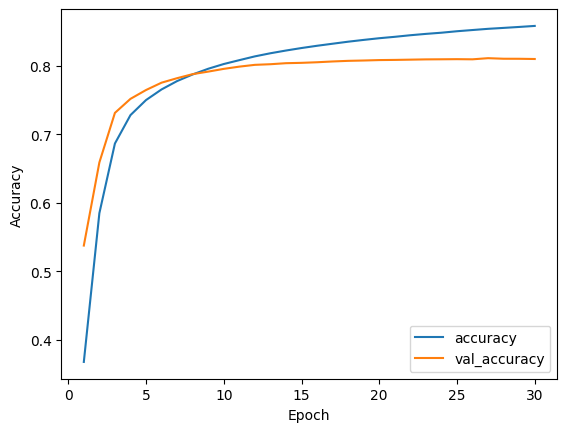

In [ ]:
acc=history.history['masked_accuracy']
val_acc=history.history['val_masked_accuracy']
epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

Maar dat we in de praktijk zien dat hij de woorddelen maar wat aan elkaar husselt. Bij de TextVectorization was hij tenminste woorden aan het gebruiken die in de buurt kwamen.

In [32]:
#nog even testen
import numpy as np
import random

def decode_sequence(input_sentence):
    tokenized_input_sentence: list = dutch_tokenizer.encode(input_sentence, out_type=int)
    while len(tokenized_input_sentence) < dutch_maxlen:
        tokenized_input_sentence.append(0)

    # tokenized_input_sentence = np.array(tokenized_input_sentence)

    decoded_sentence: list = frisian_tokenizer.encode(START_TOKEN, out_type=int)
    print("DECODED", decoded_sentence)
    indices = []

    for i in range(frisian_maxlen):
        tokenized_target_sentence = decoded_sentence.copy()

        if len(tokenized_target_sentence) >= frisian_maxlen:
            print(f"{len(tokenized_target_sentence)} is meer dan {frisian_maxlen}")
            break

        while len(tokenized_target_sentence) < frisian_maxlen:
            tokenized_target_sentence.append(0)

        # tokenized_target_sentence = np.array(tokenized_target_sentence)

        # print(tokenized_input_sentence.shape)
        # print(tokenized_target_sentence.shape)

        # inp=np.array(tokenized_input_sentence, tokenized_target_sentence)
        inp=[tf.constant([tokenized_input_sentence]), tf.constant([tokenized_target_sentence])]

        predictions = model(inp)

        # Pak altijd de laatste voorspelling
        sampled_token_index = np.argmax(predictions[0, i, :])
        indices.append(sampled_token_index)

        # sampled_token = fy_index_lookup[sampled_token_index]
        # sampled_token = decode_frisian([sampled_token_index])
        # decoded_sentence += " " + sampled_token

        # if sampled_token == END_TOKEN:
        #     break
        decoded_sentence.append(int(sampled_token_index))

    return frisian_tokenizer.decode_ids(decoded_sentence)

test_dutch_texts = [pair[0] for pair in test_pairs.values]
for _ in range(5):
    input_sentence = random.choice(test_dutch_texts)
    print("-----------------------------------------------------------")
    print("NL:", input_sentence)
    print("FY:", decode_sequence(input_sentence))


-----------------------------------------------------------
NL: ik ging naar de vrouwenarts hij onderzocht me en zei dat ik in de menopauze zat
DECODED [4, 8, 3972]
50 is meer dan 50
FY: [BOS]BOS] ik gie ik gie nei under nei dets de frouljusiid frouljush seiochtocht datsjesje ik siet siet yn [ [ [EOSEOSEOS]]]] [ oan oanEOS [ []]] op [
-----------------------------------------------------------
NL: dood bier
DECODED [4, 8, 3972]
50 is meer dan 50
FY: [BOS]BOS] dea bier in [ [ kEOSEOSoek]]]] [ [ [EOSEOSEOS]]]]] [ [ [EOSEOSEOS]]]] [ [ [EOSEOSEOS]]]] [
-----------------------------------------------------------
NL: vanaf oktober
DECODED [4, 8, 3972]
50 is meer dan 50
FY: [BOS]BOS] sunt oktober sunt [ [ isEOSEOS []]]]] [ [ [EOSEOSEOS]]]]] [ [ [EOSEOSEOS]]]]] [ [ [EOSEOSEOS]]]
-----------------------------------------------------------
NL: de makers beschikten niet over lichtgewicht cameras die in stof vorst of watervrije bekisting hun werk konden doen
DECODED [4, 8, 3972]
50 is meer dan 50


## 5. Evaluation

Leuk om te zien dat dit wel ergens al naar leidt. Ook al heb ik een accuraatheid van $80\%$ gehaald - waar ik overigens best trots op ben, zou ik nog graag verder willen door bijvoorbeeld de GloVe-inbeddings af te maken, meer hyperparameters tunen, bestaande modellen zoals BERT proberen, etc.

### 6. Deployment
Je kunt het model deployen door het artikel [Save, serialize, and export models](https://keras.io/guides/serialization_and_saving/) te volgen van keras.

Dit model kun je dan op een Python-WebAPI-server zetten (zoals [Django](https://www.djangoproject.com/)), die dan de tokens streamt naar de user, met bijvoorbeeld [WebSockets](https://websockets.spec.whatwg.org/).